<a href="https://colab.research.google.com/github/Sergei-Volkov/CellsCounter/blob/main/NeuralNetworkTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [299]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2 as cv
import albumentations as A

In [2]:
train_on_gpu = torch.cudis_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset'
os.chdir(path)

In [300]:
def get_files_names(path: str):
    files_images, files_masks = [], []
    for percent in ['00', '15', '30', '45', '60']:
        files_images_temp = next(os.walk(path + '/synthetic_0' + percent + '_images'))
        files_images += [files_images_temp[0] + '/' + name for name in sorted(files_images_temp[-1], key=lambda k: int(k[:-8]))]
        files_masks_temp = next(os.walk(path + '/synthetic_0' + percent + '_foreground'))
        files_masks += [files_masks_temp[0] + '/' + name for name in sorted(files_masks_temp[-1], key=lambda k: int(k[:-4]))]
    return np.array(files_images), np.array(files_masks)

In [305]:
def strong_aug(p=1.0, input_size=256):
    return Compose([
        A.RandomCrop(input_size, input_size, always_apply=True),
        A.ShiftScaleRotate(shift_limit=10, scale_limit=0.2, rotate_limit=180, p=1),
        A.IAAAdditiveGaussianNoise(scale=(0.01, 0.05), p=1),
        A.RandomBrightnessContrast(p=1),

    ])


def batch_generator(files_images: np.ndarray, files_masks: np.ndarray, batch_size: int):
    dataset_size = files_images.size
    while True:
        x_batch = []
        y_batch = []
        
        prev_indexes = set()
        for i in range(batch_size):
            rnd_index = np.random.randint(dataset_size)
            while rnd_index in prev_indexes:
                rnd_index = np.random.randint(dataset_size)
            prev_indexes.add(rnd_index)

            img_file, mask_file = files_images[rnd_index], files_masks[rnd_index]
            img = cv.imread(img_file)
            mask = cv.imread(mask_file)

            augmentation = strong_aug(input_size=256)
            aug = augmentation(image=imgs[0].astype('float32'), mask=masks[0])
            
            img = np.dot(aug['image'], [0.2989, 0.5870, 0.1140])
            mask = aug['mask'][:, :, 0]
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, y_batch

In [306]:
imgs, masks = next(batch_generator(*get_files_names(path), 3))

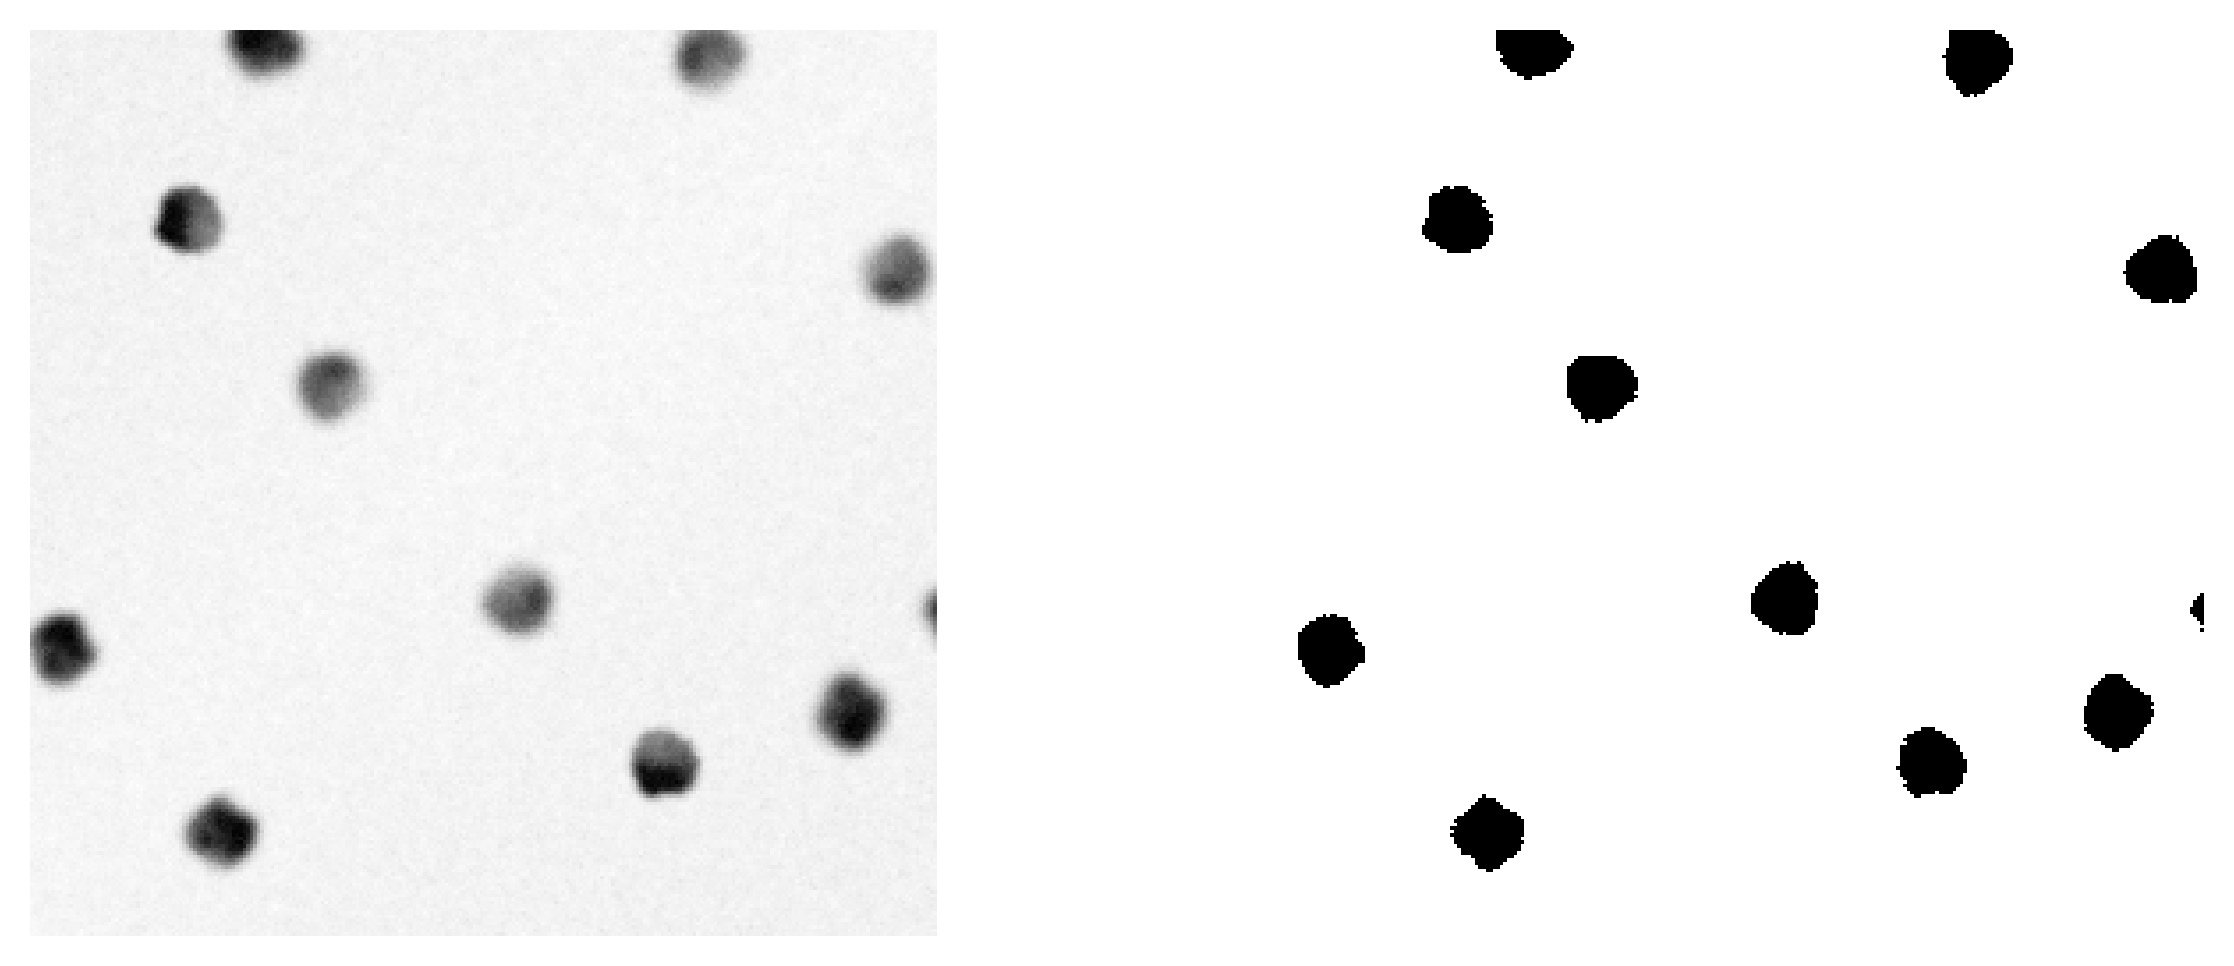

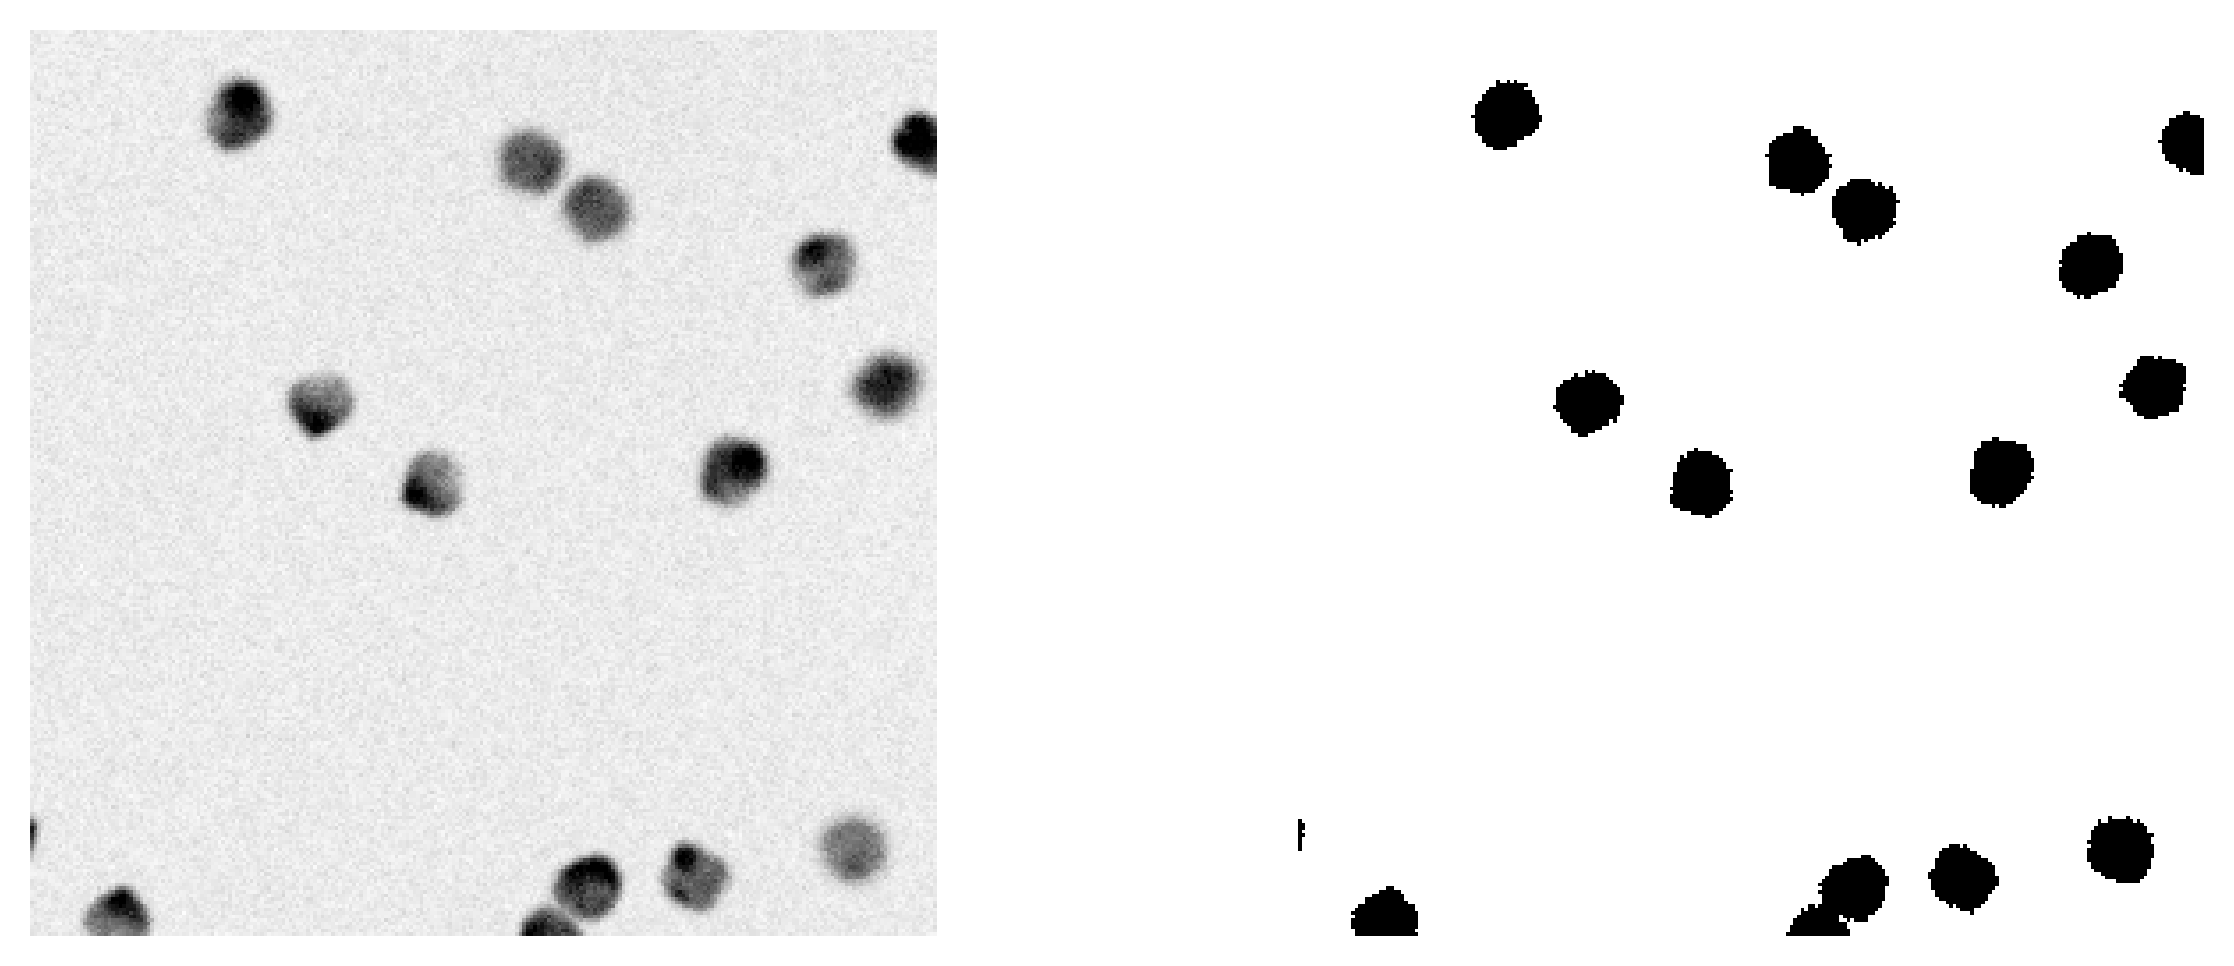

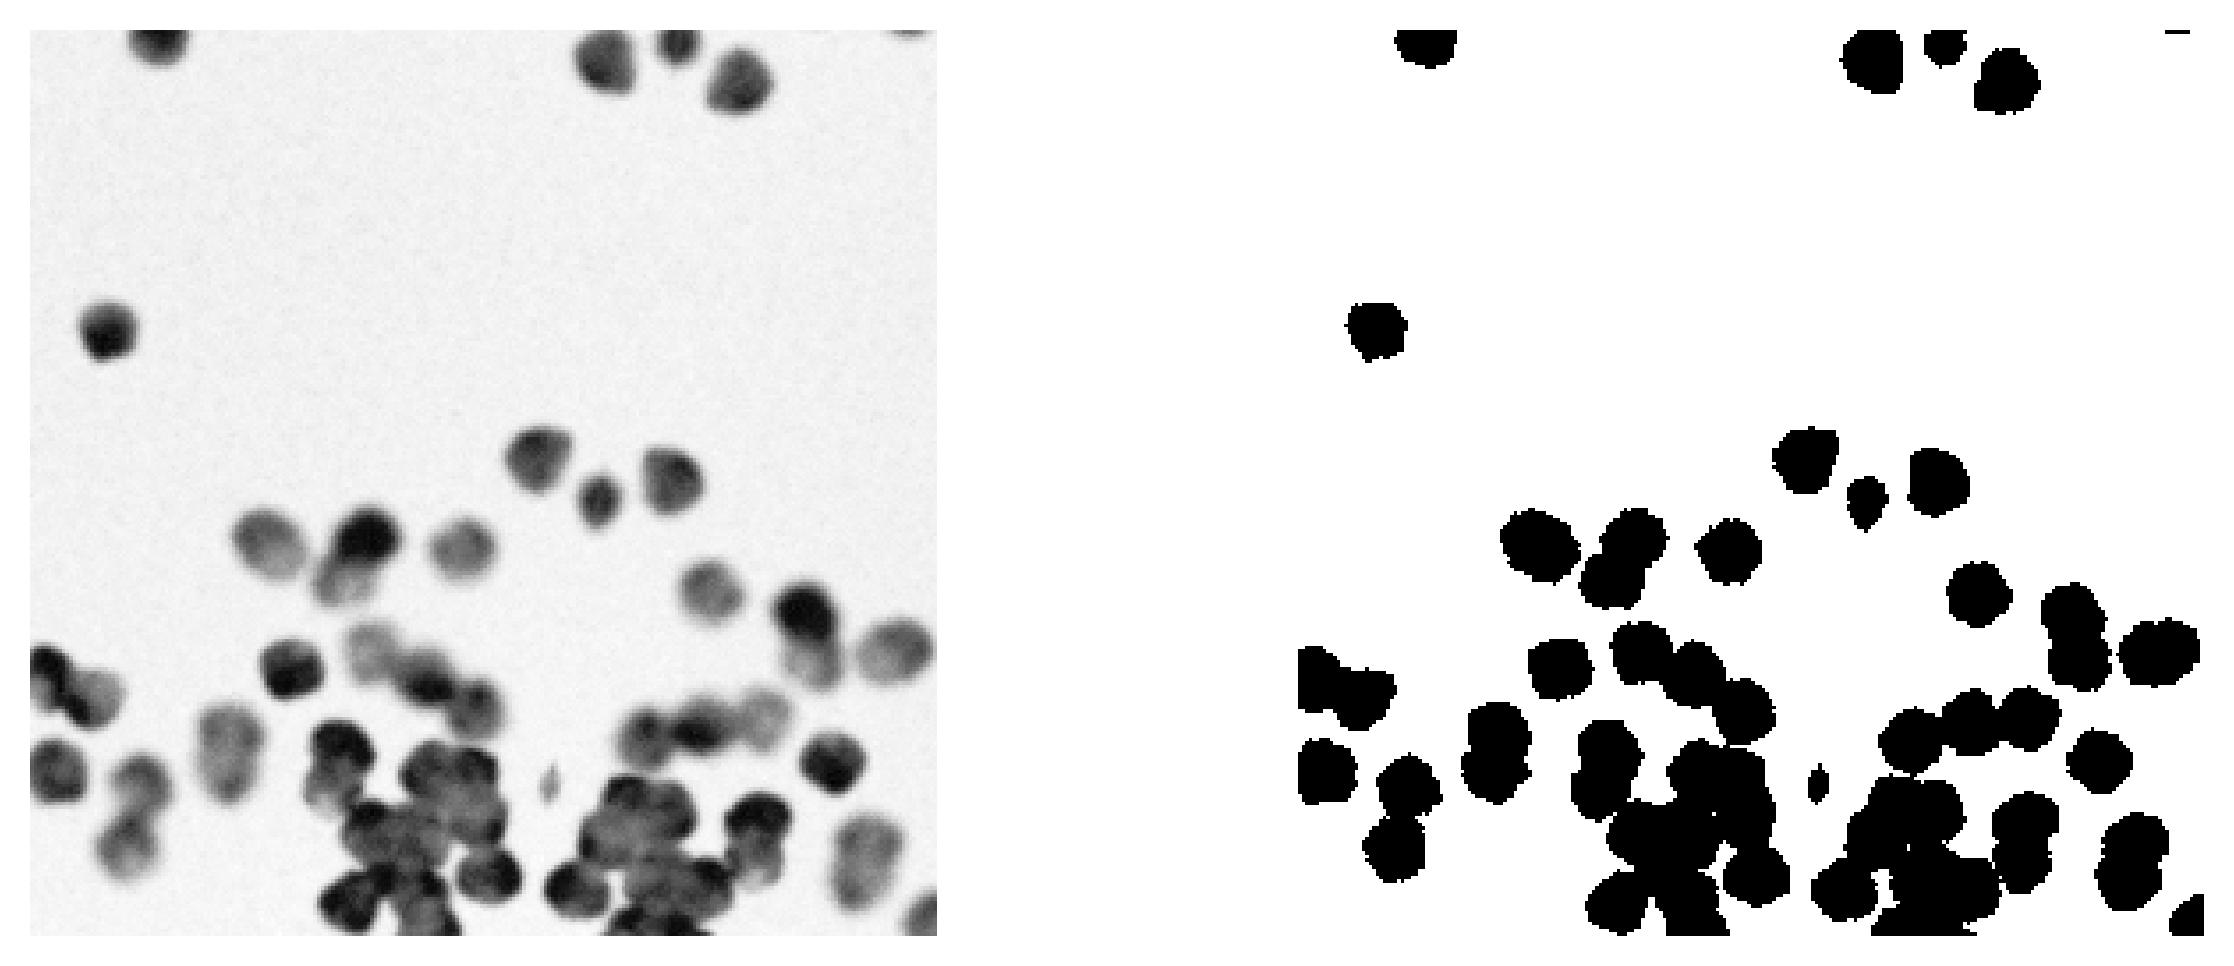

In [307]:
for j in range(3):
    plt.figure(dpi=300, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(imgs[j], cmap='Greys')
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(masks[j], cmap='Greys')